# LangChain: Q&A over Documents

An example might be a tool that would allow you to query a product catalog for items of interest.

In [ ]:
#pip install --upgrade langchain

In [1]:
import os

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

In [2]:
# account for deprecation of LLM model
import datetime
# Get the current date
current_date = datetime.datetime.now().date()

# Define the date after which the model should be set to "gpt-3.5-turbo"
target_date = datetime.date(2024, 6, 12)

# Set the model variable based on the current date
if current_date > target_date:
    llm_model = "gpt-3.5-turbo"
else:
    llm_model = "gpt-3.5-turbo-0301"

In [3]:
from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI
from langchain.document_loaders import CSVLoader
from langchain.vectorstores import DocArrayInMemorySearch
from IPython.display import display, Markdown
from langchain.llms import OpenAI

In [4]:
file = 'OutdoorClothingCatalog_1000.csv'
loader = CSVLoader(file_path=file)

In [5]:
from langchain.indexes import VectorstoreIndexCreator

In [6]:
#pip install docarray

In [7]:
index = VectorstoreIndexCreator(
    vectorstore_cls=DocArrayInMemorySearch
).from_loaders([loader])

In [8]:
query ="Please list all your shirts with sun protection \
in a table in markdown and summarize each one."

**Note**:
- The notebook uses `langchain==0.0.179` and `openai==0.27.7`
- For these library versions, `VectorstoreIndexCreator` uses `text-davinci-003` as the base model, which has been deprecated since 1 January 2024.
- The replacement model, `gpt-3.5-turbo-instruct` will be used instead for the `query`.
- The `response` format might be different than the video because of this replacement model.

In [9]:
llm_replacement_model = OpenAI(temperature=0, 
                               model='gpt-3.5-turbo-instruct')

response = index.query(query, 
                       llm = llm_replacement_model)

In [10]:
display(Markdown(response))



| Name | Description | Sun Protection Rating |
| --- | --- | --- |
| Men's Tropical Plaid Short-Sleeve Shirt | Made of 100% polyester, UPF 50+ rating, wrinkle-resistant, front and back cape venting, two front bellows pockets | SPF 50+, blocks 98% of harmful UV rays |
| Men's Plaid Tropic Shirt, Short-Sleeve | Made of 52% polyester and 48% nylon, UPF 50+ rating, wrinkle-free, front and back cape venting, two front bellows pockets | SPF 50+, blocks 98% of harmful UV rays |
| Men's TropicVibe Shirt, Short-Sleeve | Made of 71% nylon and 29% polyester, UPF 50+ rating, wrinkle-resistant, front and back cape venting, two front bellows pockets | SPF 50+, blocks 98% of harmful UV rays |
| Sun Shield Shirt | Made of 78% nylon and 22% Lycra Xtra Life fiber, UPF 50+ rating, moisture-wicking, abrasion-resistant, fits over swimsuit | SPF 50+, blocks 98% of harmful UV rays |

## Step By Step

In [11]:
from langchain.document_loaders import CSVLoader
loader = CSVLoader(file_path=file)

In [12]:
docs = loader.load()

In [13]:
docs[0]

Document(page_content=": 0\nname: Women's Campside Oxfords\ndescription: This ultracomfortable lace-to-toe Oxford boasts a super-soft canvas, thick cushioning, and quality construction for a broken-in feel from the first time you put them on. \n\nSize & Fit: Order regular shoe size. For half sizes not offered, order up to next whole size. \n\nSpecs: Approx. weight: 1 lb.1 oz. per pair. \n\nConstruction: Soft canvas material for a broken-in feel and look. Comfortable EVA innersole with Cleansport NXT® antimicrobial odor control. Vintage hunt, fish and camping motif on innersole. Moderate arch contour of innersole. EVA foam midsole for cushioning and support. Chain-tread-inspired molded rubber outsole with modified chain-tread pattern. Imported. \n\nQuestions? Please contact us for any inquiries.", metadata={'source': 'OutdoorClothingCatalog_1000.csv', 'row': 0})

In [14]:
from langchain.embeddings import OpenAIEmbeddings
embeddings = OpenAIEmbeddings()

In [15]:
embed = embeddings.embed_query("Hi my name is Harrison")

In [16]:
print(len(embed))

1536


In [17]:
print(embed[:5])

[-0.0219351164996624, 0.006751196924597025, -0.0182583499699831, -0.03915192559361458, -0.013979244977235794]


In [18]:
db = DocArrayInMemorySearch.from_documents(
    docs, 
    embeddings
)

In [19]:
query = "Please suggest a shirt with sunblocking"

In [20]:
docs = db.similarity_search(query)

In [21]:
len(docs)

4

In [22]:
docs[0]

Document(page_content=': 255\nname: Sun Shield Shirt by\ndescription: "Block the sun, not the fun – our high-performance sun shirt is guaranteed to protect from harmful UV rays. \n\nSize & Fit: Slightly Fitted: Softly shapes the body. Falls at hip.\n\nFabric & Care: 78% nylon, 22% Lycra Xtra Life fiber. UPF 50+ rated – the highest rated sun protection possible. Handwash, line dry.\n\nAdditional Features: Wicks moisture for quick-drying comfort. Fits comfortably over your favorite swimsuit. Abrasion resistant for season after season of wear. Imported.\n\nSun Protection That Won\'t Wear Off\nOur high-performance fabric provides SPF 50+ sun protection, blocking 98% of the sun\'s harmful rays. This fabric is recommended by The Skin Cancer Foundation as an effective UV protectant.', metadata={'source': 'OutdoorClothingCatalog_1000.csv', 'row': 255})

In [23]:
retriever = db.as_retriever()

In [24]:
llm = ChatOpenAI(temperature = 0.0, model=llm_model)

In [25]:
qdocs = "".join([docs[i].page_content for i in range(len(docs))])


In [26]:
response = llm.call_as_llm(f"{qdocs} Question: Please list all your \
shirts with sun protection in a table in markdown and summarize each one.") 


In [27]:
display(Markdown(response))

| Shirt Name | Description |
| --- | --- |
| Sun Shield Shirt | High-performance sun shirt with UPF 50+ sun protection, moisture-wicking, and abrasion-resistant fabric. Recommended by The Skin Cancer Foundation. |
| Men's Plaid Tropic Shirt | Ultracomfortable shirt with UPF 50+ sun protection, wrinkle-free fabric, and front/back cape venting. Made with 52% polyester and 48% nylon. |
| Men's TropicVibe Shirt | Men's sun-protection shirt with built-in UPF 50+ and front/back cape venting. Made with 71% nylon and 29% polyester. |
| Men's Tropical Plaid Short-Sleeve Shirt | Lightest hot-weather shirt with UPF 50+ sun protection, front/back cape venting, and two front bellows pockets. Made with 100% polyester and is wrinkle-resistant. |

All of these shirts provide UPF 50+ sun protection, blocking 98% of the sun's harmful rays. They are made with high-performance fabrics that are moisture-wicking, wrinkle-resistant, and abrasion-resistant. The Men's Plaid Tropic Shirt and Men's Tropical Plaid Short-Sleeve Shirt both have front/back cape venting for added breathability. The Sun Shield Shirt is recommended by The Skin Cancer Foundation as an effective UV protectant.

In [28]:
qa_stuff = RetrievalQA.from_chain_type(
    llm=llm, 
    chain_type="stuff", 
    retriever=retriever, 
    verbose=True
)

In [29]:
query =  "Please list all your shirts with sun protection in a table \
in markdown and summarize each one."

In [30]:
response = qa_stuff.run(query)



> Entering new RetrievalQA chain...

> Finished chain.


In [31]:
display(Markdown(response))

| Shirt Number | Name | Description |
| --- | --- | --- |
| 618 | Men's Tropical Plaid Short-Sleeve Shirt | This shirt is made of 100% polyester and is wrinkle-resistant. It has front and back cape venting that lets in cool breezes and two front bellows pockets. It is rated UPF 50+ for superior protection from the sun's UV rays. |
| 374 | Men's Plaid Tropic Shirt, Short-Sleeve | This shirt is made with 52% polyester and 48% nylon. It is machine washable and dryable. It has front and back cape venting, two front bellows pockets, and is rated to UPF 50+. |
| 535 | Men's TropicVibe Shirt, Short-Sleeve | This shirt is made of 71% Nylon and 29% Polyester. It has front and back cape venting that lets in cool breezes and two front bellows pockets. It is rated UPF 50+ for superior protection from the sun's UV rays. |
| 255 | Sun Shield Shirt | This shirt is made of 78% nylon and 22% Lycra Xtra Life fiber. It is handwashable and line dry. It is rated UPF 50+ for superior protection from the sun's UV rays. It is abrasion-resistant and wicks moisture for quick-drying comfort. |

The Men's Tropical Plaid Short-Sleeve Shirt is made of 100% polyester and is wrinkle-resistant. It has front and back cape venting that lets in cool breezes and two front bellows pockets. It is rated UPF 50+ for superior protection from the sun's UV rays.

The Men's Plaid Tropic Shirt, Short-Sleeve is made with 52% polyester and 48% nylon. It has front and back cape venting, two front bellows pockets, and is rated to UPF 50+.

The Men's TropicVibe Shirt, Short-Sleeve is made of 71% Nylon and 29% Polyester. It has front and back cape venting that lets in cool breezes and two front bellows pockets. It is rated UPF 50+ for superior protection from the sun's UV rays.

The Sun Shield Shirt is made of 78% nylon and 22% Lycra Xtra Life fiber. It is abrasion-resistant and wicks moisture for quick-drying comfort. It is rated UPF 50+ for superior protection from the sun's UV rays. It is handwashable and line dry.

In [32]:
response = index.query(query, llm=llm)

In [33]:
index = VectorstoreIndexCreator(
    vectorstore_cls=DocArrayInMemorySearch,
    embedding=embeddings,
).from_loaders([loader])

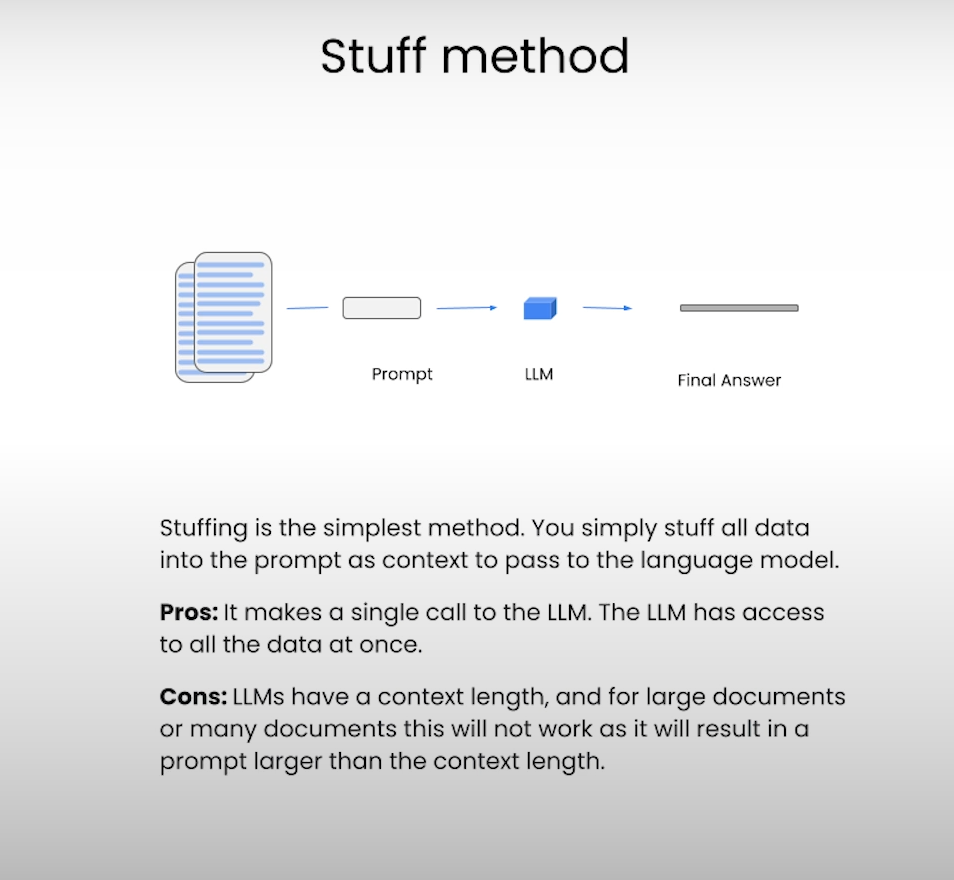

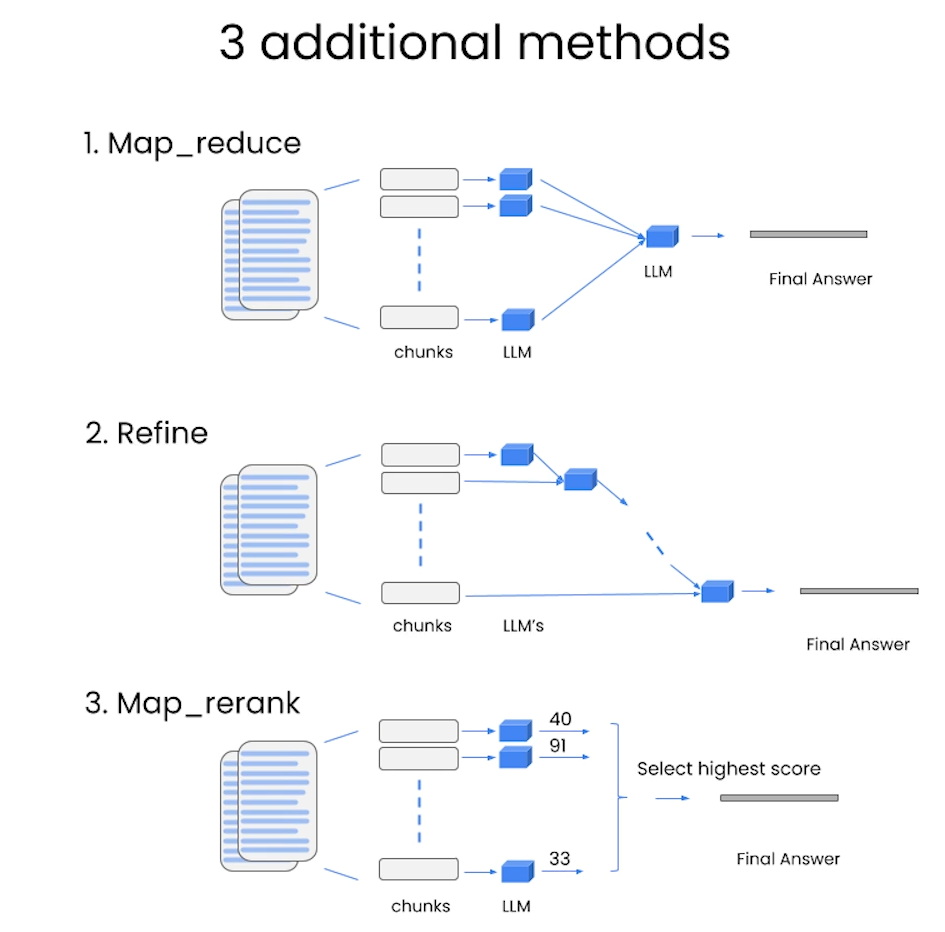